# Home Credit Loans - Your Future, Our Passion



![alt text](http://www.homecredit.net/~/media/Images/H/Home-Credit-Group/banners/innovations-speed-and-simplicity.jpg?h=570&la=en&w=1170 "Home Credit")



# Introduction

In this project, we will have a look ath the home credit dataset from kaggle, which you can get here:
https://www.kaggle.com/c/home-credit-default-risk/
To get a comparable result, we will use the ROC-AUC score as a perfomance metric as well (and it makes sense).

The goal is to maximize the potential customers, so we can give as many people as possible a loan.
In this notebook we will have a look at the dataset and do some clearing and simple feature engineering.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn

In [2]:
df = pd.read_csv("data/application_train.csv")

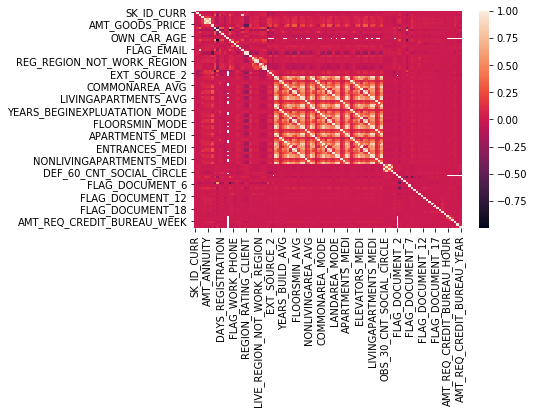

In [3]:
sn.heatmap(df.corr())

In [4]:
df.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [5]:
# get all columns with NaN's
df_nan = df.loc[:, df.isna().any()]


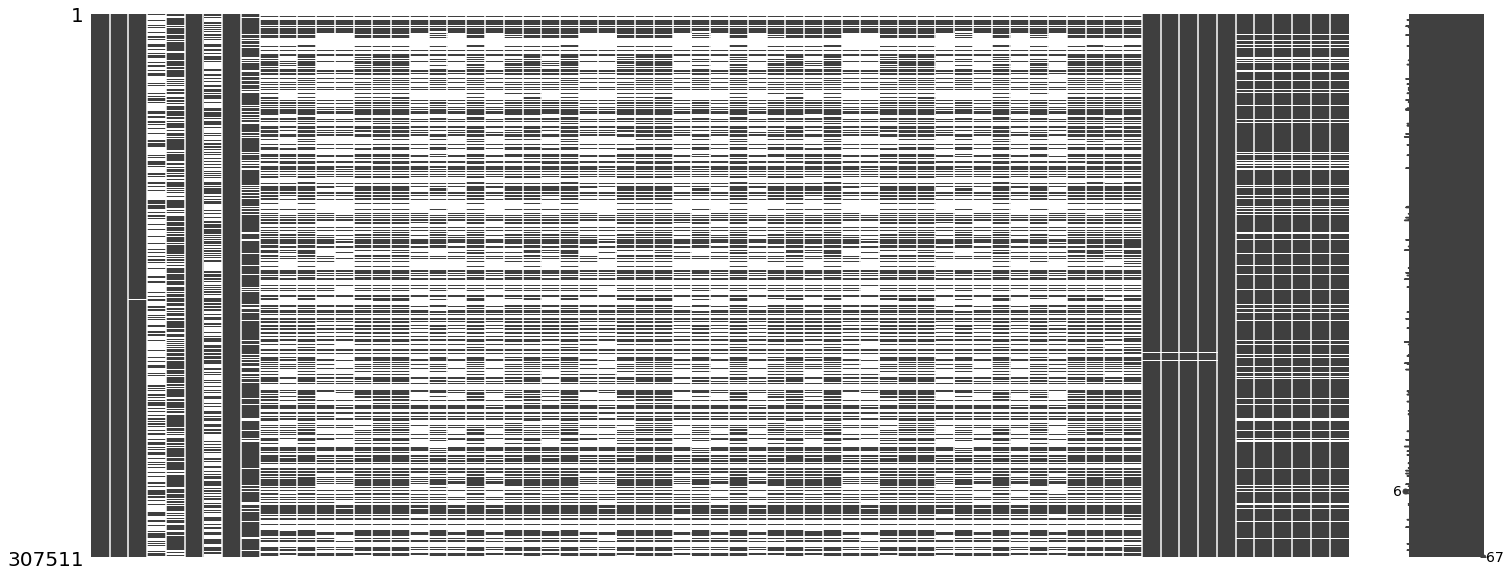

In [6]:
import missingno as msno
msno.matrix(df_nan)


In [7]:
# clean all the columns with less missing data
df_nan.isna().sum()[df_nan.isna().sum() < 30000]

AMT_ANNUITY                   12
AMT_GOODS_PRICE              278
NAME_TYPE_SUITE             1292
CNT_FAM_MEMBERS                2
EXT_SOURCE_2                 660
OBS_30_CNT_SOCIAL_CIRCLE    1021
DEF_30_CNT_SOCIAL_CIRCLE    1021
OBS_60_CNT_SOCIAL_CIRCLE    1021
DEF_60_CNT_SOCIAL_CIRCLE    1021
DAYS_LAST_PHONE_CHANGE         1
dtype: int64

In [8]:
# the median or most common value is taken for the missing values

df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(df["AMT_ANNUITY"].median())
df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].fillna(df["AMT_GOODS_PRICE"].median())
df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].fillna("Unaccompanied")
df["DAYS_LAST_PHONE_CHANGE"] = df["DAYS_LAST_PHONE_CHANGE"].fillna(df["DAYS_LAST_PHONE_CHANGE"].median())
df["CNT_FAM_MEMBERS"] = df["CNT_FAM_MEMBERS"].fillna(df["CNT_FAM_MEMBERS"].median())
df["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].fillna(df["EXT_SOURCE_2"].median())



In [9]:

# in cnt_social_circle seems to be a pattern
social_circle = "OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE".split(",")

# have a look how the proportion is inside the nan values
df.loc[df["OBS_30_CNT_SOCIAL_CIRCLE"].isna(),social_circle + ["TARGET"]].TARGET.value_counts()

df[social_circle + ["TARGET"]].groupby("TARGET").mean()

# fill with the median value of target
df[social_circle] = df[social_circle].fillna(df[social_circle].median())



In [10]:
# finished cleaning small missing values

### Discuss if we can drop the following columns

In [11]:
# the columns describe if there was an inquiry at the Credit Bureau about the applicant in the time before
# as the NaN's appear in every column, it seems to be a pattern
# we assume that there was no inquiry about the person at the Credit-Bureau and fill the NaN's with 0

amt_req_cols = df.columns[df.columns.str.contains('(?i)AMT_REQ_CREDIT_BUREAU')].tolist()
df[amt_req_cols] = df[amt_req_cols].fillna(0)



In [12]:

# extract all columns which have something to do with a house
house_cols = "APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE"
house_cols = house_cols.split(",")   
#drop house columns until we know a better solution
df = df.drop(house_cols, axis=1)

In [13]:
# for future research, we could see if there are patterns between owning a house and house_features
#    df_house_features = df[["FLAG_OWN_REALTY", "TARGET"] + house_cols]
#    df_house_features.groupby("FLAG_OWN_REALTY").median().iloc[:,:15]

In [14]:
df.isna().sum()[df.isna().sum() > 30000]

OWN_CAR_AGE        202929
OCCUPATION_TYPE     96391
EXT_SOURCE_1       173378
EXT_SOURCE_3        60965
dtype: int64

In [15]:
# look at the correlations of the external sources
df[["TARGET","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].corr()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.155317,-0.160295,-0.178919
EXT_SOURCE_1,-0.155317,1.000000,0.213843,0.186846
EXT_SOURCE_2,-0.160295,0.213843,1.000000,0.109174
EXT_SOURCE_3,-0.178919,0.186846,0.109174,1.000000


In [16]:
# build the mean and look at correlations again
df["EXT_SOURCE_AVG"] = df[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].mean(axis=1)
df[["TARGET","EXT_SOURCE_AVG"]].corr()



,TARGET,EXT_SOURCE_AVG
TARGET,1.000000,-0.222079
EXT_SOURCE_AVG,-0.222079,1.000000


In [17]:
df_all_amt_cols = df.columns[df.columns.str.contains('(?i)SUM')].tolist()

len(df[df_all_amt_cols].columns)


0

In [18]:
# as we have a better correlation, we can drop the original external sources
df = df.drop(["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"], axis=1)


In [19]:
# checking if missing values are still there
df["EXT_SOURCE_AVG"].isna().any()

False

In [20]:
# looking at occupation type

print(df["OCCUPATION_TYPE"].value_counts())
# as this seems to be only additional information, the default value might be NaN.
# since we don't want to miss these entries, we change them to Unknown
df["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)

df["OCCUPATION_TYPE"].isna().any()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64


False

In [21]:
# here we can do some feature engineering. for the first trials we will drop the column

df = df.drop("OWN_CAR_AGE", axis=1)



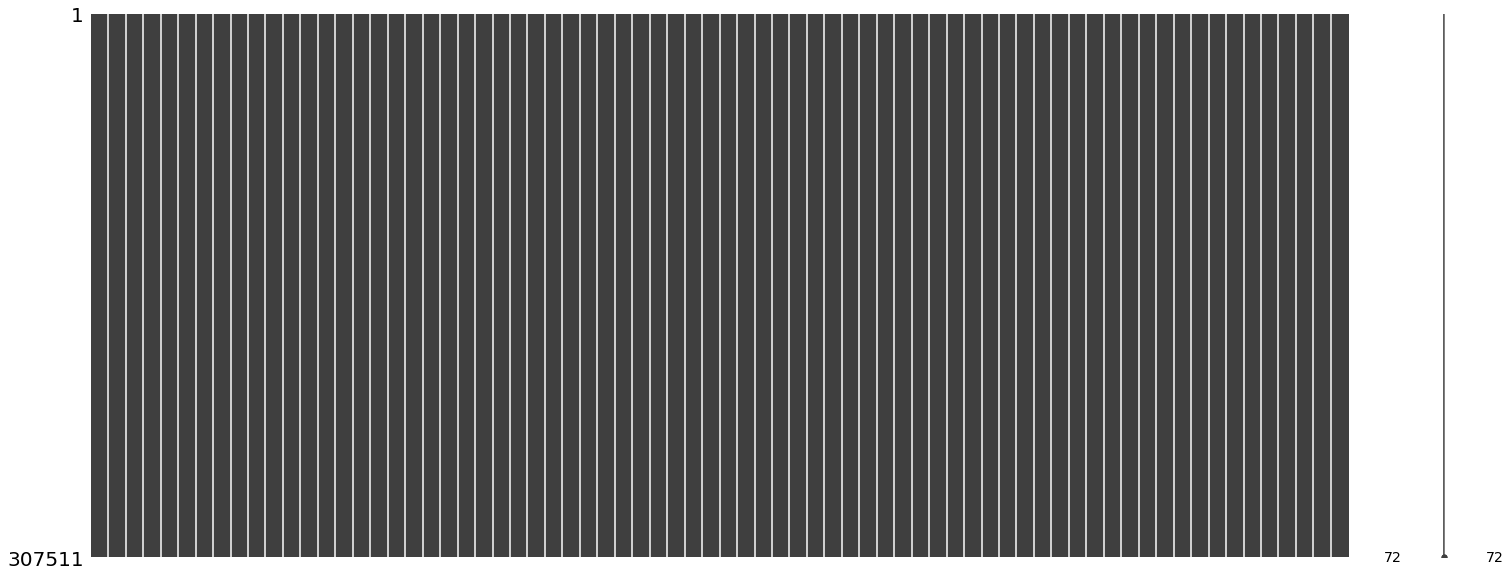

In [22]:
msno.matrix(df)


In [23]:
len(df.columns)

72

In [24]:
#df.drop(["SK_ID_CURR"], axis=1, inplace = True)

df.head(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_AVG
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.161787


# Feature Engineering

In [25]:
df_doc_cols = df.columns[df.columns.str.contains('(?i)DOCU')].tolist()

df.drop(df_doc_cols, axis= 1, inplace= True)

len(df.columns)

52

In [26]:
df.corr()["TARGET"]

SK_ID_CURR                    -0.002108
TARGET                         1.000000
CNT_CHILDREN                   0.019187
AMT_INCOME_TOTAL              -0.003982
AMT_CREDIT                    -0.030369
AMT_ANNUITY                   -0.012815
AMT_GOODS_PRICE               -0.039623
REGION_POPULATION_RELATIVE    -0.037227
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                 -0.044932
DAYS_REGISTRATION              0.041975
DAYS_ID_PUBLISH                0.051457
FLAG_MOBIL                     0.000534
FLAG_EMP_PHONE                 0.045982
FLAG_WORK_PHONE                0.028524
FLAG_CONT_MOBILE               0.000370
FLAG_PHONE                    -0.023806
FLAG_EMAIL                    -0.001758
CNT_FAM_MEMBERS                0.009308
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
HOUR_APPR_PROCESS_START       -0.024166
REG_REGION_NOT_LIVE_REGION     0.005576
REG_REGION_NOT_WORK_REGION     0.006942
LIVE_REGION_NOT_WORK_REGION    0.002819


In [27]:
# 

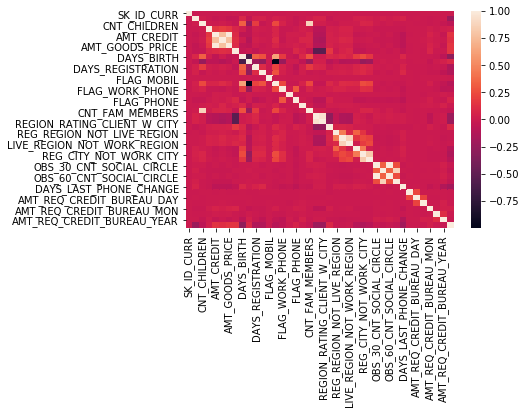

In [28]:
sn.heatmap(df.iloc[:,:].corr())

In [29]:
# highly correlated features

amt_cols = "AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE".split(",")

df[amt_cols].corr()




,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
AMT_INCOME_TOTAL,1.000000,0.156870,0.191657,0.159632
AMT_CREDIT,0.156870,1.000000,0.770127,0.986734
AMT_ANNUITY,0.191657,0.770127,1.000000,0.774837
AMT_GOODS_PRICE,0.159632,0.986734,0.774837,1.000000


In [30]:
df.drop("AMT_GOODS_PRICE", axis=1, inplace=True)

In [31]:
# find better feature for correlated features

df[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]]

df["ANNUITY_INCOME_RAT"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]

df[["TARGET","AMT_INCOME_TOTAL", "AMT_ANNUITY", "ANNUITY_INCOME_RAT"]].corr()

df.drop(["AMT_INCOME_TOTAL","AMT_ANNUITY"], axis=1, inplace =True)



In [32]:
# features "social cirlce" are highly correlated under each other

df["SOCIAL_CIRCLE_AVG"] = df[social_circle].mean(axis=1)
df.drop(social_circle, axis=1, inplace=True)




In [33]:
# region and city rating - multiplying both features
# bad neighborhood in bad city results in low score, good in good city in high score

df_region_cols = ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]
df["REGION_RATING_BOOST"] =  df["REGION_RATING_CLIENT"] * df["REGION_RATING_CLIENT_W_CITY"]

df.drop(df_region_cols, axis=1, inplace=True)


In [34]:
# if there was a mismatch between adress in any of the three columns
# if so, new column with 1, else 0

df_live_cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY"]

df["REGION_MISMATCH"] = df[df_live_cols].any(1).astype(int)

df.drop(df_live_cols, axis=1, inplace=True)



In [35]:
#sn.heatmap(df.iloc[:,:].corr())

In [36]:
# Organization type / delete

df_orga_cols = df.columns[df.columns.str.contains('(?i)ORGANIZATION')].tolist()

df.drop(df_orga_cols,axis=1,inplace=True)

In [37]:
# the columns describe if there was an inquiry at the Credit Bureau about the applicant in the time before
# most interesting seems to be the inquiries in last year and one month before
# it seems that only the quarter and the year seem to have an impact

df_req_cb_cols = ["AMT_REQ_CREDIT_BUREAU_HOUR"
                ,"AMT_REQ_CREDIT_BUREAU_DAY"
                ,"AMT_REQ_CREDIT_BUREAU_WEEK"
                ,"AMT_REQ_CREDIT_BUREAU_MON"
                ,"AMT_REQ_CREDIT_BUREAU_QRT"]




df["AMT_REQ_CREDIT_BUREAU_QUARTER_SUM"] = df[["AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT" ]].sum(axis=1)


#df[df_req_cb_cols + ["TARGET", "AMT_REQ_CREDIT_BUREAU_SUM", "AMT_REQ_CREDIT_BUREAU_QUARTER_SUM"]].groupby("TARGET").mean()


df.drop(df_req_cb_cols, axis=1, inplace=True)


In [38]:
# See if the customer is familiar with modern technology

df_modern_tech_cols = df.columns[df.columns.str.contains('(?i)FLAG')].tolist()

df["TECH_SCORE"] = df[df_modern_tech_cols[:-2]].sum(axis=1)


df[["TARGET", "TECH_SCORE"] + df_modern_tech_cols].corr()

df.drop(df_modern_tech_cols[:-2], axis=1, inplace = True)


In [39]:
#drop weekday start

df_weekday_cols = df.columns[df.columns.str.contains('(?i)WEEKDAY')].tolist()
df[df_weekday_cols + ["TARGET"]].corr()

df.drop(df_weekday_cols, axis=1, inplace= True)




In [40]:
# at what time did the survey start

df_hour_cols = df.columns[df.columns.str.contains('(?i)HOUR_APPR')].tolist()

df.drop(df_hour_cols, axis=1, inplace= True)





In [41]:
#Drop and clean tiny classes in NAME_INCOME_TYPE
#or 'Student' or 'Unemployed')
df = df[df.NAME_INCOME_TYPE != 'Maternity leave']
df = df[df.NAME_INCOME_TYPE != 'Student']
df = df[df.NAME_INCOME_TYPE != 'Unemployed']
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace('Businessman','Commercial associate')
#df['NAME_INCOME_TYPE'].drop()

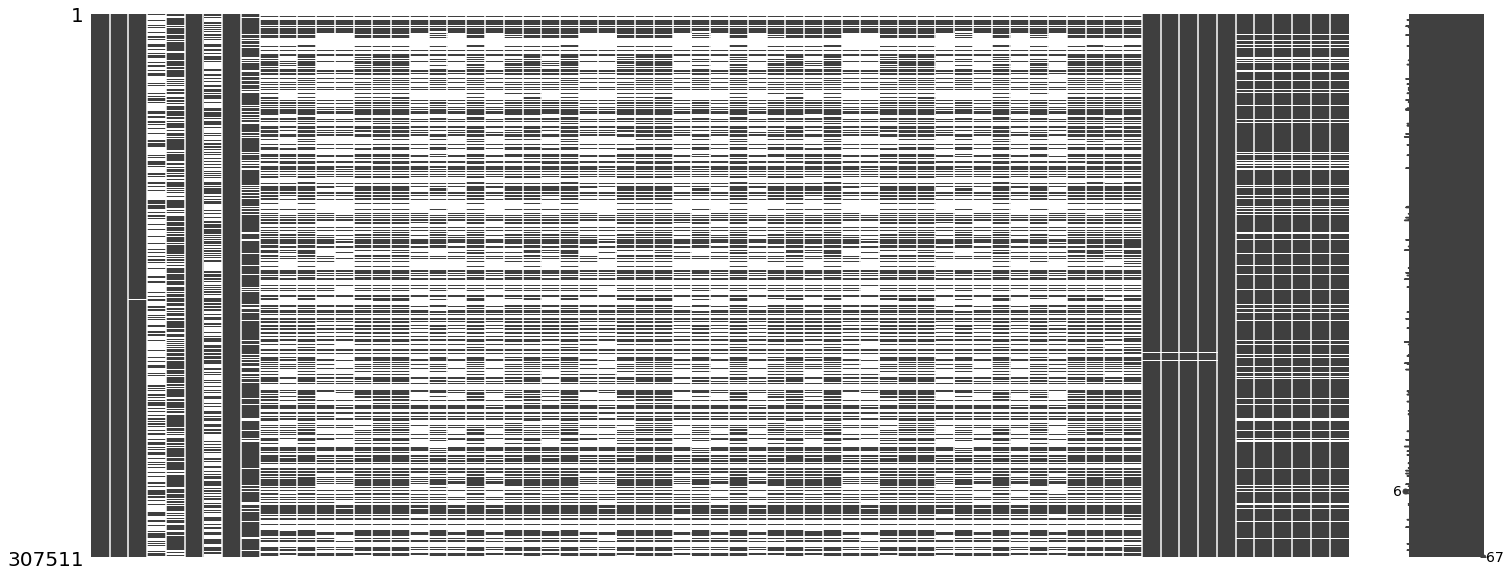

In [42]:
import missingno as msno
msno.matrix(df_nan)


In [43]:
#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [44]:
# get dummies for categorical data and drop first column for independency

df = pd.get_dummies(df, drop_first=True)






In [45]:
#sn.heatmap(df.corr())

In [46]:
# resetting index before scaling
df.reset_index(inplace=True, drop=True)

df.dtypes

SK_ID_CURR                                             int64
TARGET                                                 int64
CNT_CHILDREN                                           int64
AMT_CREDIT                                           float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                             int64
DAYS_EMPLOYED                                          int64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                        int64
FLAG_PHONE                                             int64
FLAG_EMAIL                                             int64
CNT_FAM_MEMBERS                                      float64
LIVE_CITY_NOT_WORK_CITY                                int64
DAYS_LAST_PHONE_CHANGE                               float64
AMT_REQ_CREDIT_BUREAU_YEAR                           float64
EXT_SOURCE_AVG                                       float64
ANNUITY_INCOME_RAT      

In [47]:
numerical_features = df.select_dtypes(
    include = ["int64", "float64"]).drop("TARGET", axis=1)
categorical_features = df.select_dtypes(
    exclude = ["int64", "float64"])

In [48]:
from sklearn.preprocessing import StandardScaler


#scaling numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(numerical_features)

df_numerical = pd.DataFrame(data = scaled_numerical, columns=numerical_features.columns)

df_scaled = pd.concat([df["TARGET"],df_numerical, categorical_features], axis=1, sort=False)

len(df_scaled.columns)

66

In [49]:
%store df_scaled
%store df

Stored 'df_scaled' (DataFrame)
Stored 'df' (DataFrame)


# Function for test-dataset

In [50]:
# the median or most common value is taken for the missing values

def clean_data(df):
    df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(df["AMT_ANNUITY"].median())
    df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].fillna(df["AMT_GOODS_PRICE"].median())
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].fillna("Unaccompanied")
    df["DAYS_LAST_PHONE_CHANGE"] = df["DAYS_LAST_PHONE_CHANGE"].fillna(df["DAYS_LAST_PHONE_CHANGE"].median())
    df["CNT_FAM_MEMBERS"] = df["CNT_FAM_MEMBERS"].fillna(df["CNT_FAM_MEMBERS"].median())
    df["EXT_SOURCE_2"] = df["EXT_SOURCE_2"].fillna(df["EXT_SOURCE_2"].median())

    # in cnt_social_circle seems to be a pattern
    social_circle = "OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE".split(",")

    df["SOCIAL_CIRCLE_AVG"] = df[social_circle].mean(axis=1)
    df.drop(social_circle, axis=1, inplace=True)


    amt_req_cols = df.columns[df.columns.str.contains('(?i)AMT_REQ_CREDIT_BUREAU')].tolist()
    df[amt_req_cols] = df[amt_req_cols].fillna(0)
    # extract all columns which have something to do with a house
    house_cols = "APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE"
    house_cols = house_cols.split(",")   
    #drop house columns until we know a better solution
    df = df.drop(house_cols, axis=1)
    
    
    df["EXT_SOURCE_AVG"] = df[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]].mean(axis=1)

    df = df.drop(["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"], axis=1)

    df["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
    df = df.drop("OWN_CAR_AGE", axis=1)

    df_doc_cols = df.columns[df.columns.str.contains('(?i)DOCU')].tolist()

    df.drop(df_doc_cols, axis= 1, inplace= True)
    df.drop("AMT_GOODS_PRICE", axis=1, inplace=True)
    
    df_region_cols = ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]
    df["REGION_RATING_BOOST"] =  df["REGION_RATING_CLIENT"] * df["REGION_RATING_CLIENT_W_CITY"]

    df.drop(df_region_cols, axis=1, inplace=True)

    df_live_cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION","LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY"]

    df["REGION_MISMATCH"] = df[df_live_cols].any(1).astype(int)

    df.drop(df_live_cols, axis=1, inplace=True)
    
    df_modern_tech_cols = df.columns[df.columns.str.contains('(?i)FLAG')].tolist()

    df["TECH_SCORE"] = df[df_modern_tech_cols[:-2]].sum(axis=1)



    df.drop(df_modern_tech_cols[:-2], axis=1, inplace = True)
    df_req_cb_cols = ["AMT_REQ_CREDIT_BUREAU_HOUR"
                ,"AMT_REQ_CREDIT_BUREAU_DAY"
                ,"AMT_REQ_CREDIT_BUREAU_WEEK"
                ,"AMT_REQ_CREDIT_BUREAU_MON"
                ,"AMT_REQ_CREDIT_BUREAU_QRT"]




    df["AMT_REQ_CREDIT_BUREAU_QUARTER_SUM"] = df[["AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT" ]].sum(axis=1)



    df.drop(df_req_cb_cols, axis=1, inplace=True)
    
    df_weekday_cols = df.columns[df.columns.str.contains('(?i)WEEKDAY')].tolist()

    df.drop(df_weekday_cols, axis=1, inplace= True) 
    df_hour_cols = df.columns[df.columns.str.contains('(?i)HOUR_APPR')].tolist()

    df.drop(df_hour_cols, axis=1, inplace= True)
    
    
    df = pd.get_dummies(df, drop_first=True)
    
    return df
    

In [51]:
df_test = pd.read_csv("data/application_test.csv")
clean_data(df_test)




,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100001,0,135000.0,568800.0,20560.5,0.018850,-19241,-2329,-5170.0,-812,...,0,0,0,0,0,0,0,0,0,0
1,100005,0,99000.0,222768.0,17370.0,0.035792,-18064,-4469,-9118.0,-1623,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,202500.0,663264.0,69777.0,0.019101,-20038,-4458,-2175.0,-3503,...,0,0,0,0,0,0,1,0,0,0
3,100028,2,315000.0,1575000.0,49018.5,0.026392,-13976,-1866,-2000.0,-4208,...,0,0,0,0,0,0,0,0,0,0
4,100038,1,180000.0,625500.0,32067.0,0.010032,-13040,-2191,-4000.0,-4262,...,0,0,0,0,0,0,0,0,0,0
5,100042,0,270000.0,959688.0,34600.5,0.025164,-18604,-12009,-6116.0,-2027,...,0,0,0,0,0,0,0,0,0,0
6,100057,2,180000.0,499221.0,22117.5,0.022800,-16685,-2580,-10125.0,-241,...,0,0,0,0,0,0,0,0,0,0
7,100065,0,166500.0,180000.0,14220.0,0.005144,-9516,-1387,-5063.0,-2055,...,0,0,0,0,0,0,0,0,0,0
8,100066,0,315000.0,364896.0,28957.5,0.046220,-12744,-1013,-1686.0,-3171,...,0,0,0,0,0,0,0,0,0,0
9,100067,1,162000.0,45000.0,5337.0,0.018634,-10395,-2625,-8124.0,-3041,...,0,0,0,0,0,0,0,0,0,0
